In [1]:
import numpy as np
import pandas as pd
import copy
from shapely.geometry import box
import geopandas as gpd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import sentinelhub

In [2]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [3]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")


In [4]:
from glob import glob
import xarray as xr

pv_farms = glob(f"{data_dir}/s2/germany/patches/*.nc")
dataset = xr.open_dataset(pv_farms[0], decode_coords="all") # 
tem_bands = list(dataset.keys())[10:]

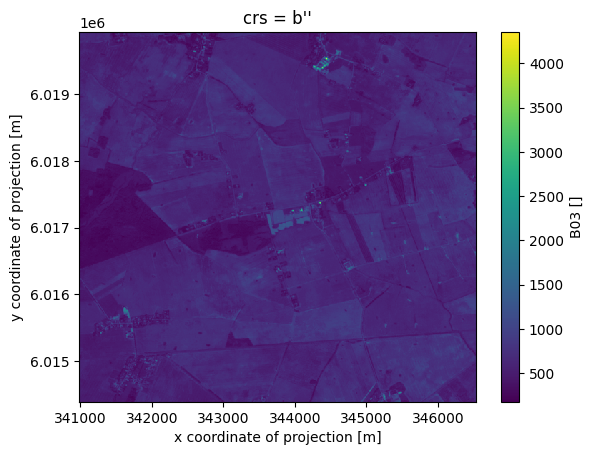

In [6]:
dataset['B03'].plot()

In [7]:
# # COCO
# #[x_min, y_min, width, height] #coordinates of the top-left corner along with the width and height of the bounding box.

netcdf_ids = []
all_farms = []
all_boxes = []
for i, pv_farm in tqdm(enumerate(pv_farms)):
    dataset = xr.open_dataset(pv_farm, decode_coords="all") 
    crs = int(dataset.crs.crs_wkt[-8:-3])
    
    transform = dataset.rio.transform()
 
    farms = pv_farm.split('.')[0].split('_')[4:]
    farms = [int(f) for f in farms] 
    
    
    bboxes = []
    for farm in farms:
        geom = big_pv_geoms.iloc[farm]
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:4326")
        
        geodf_utm = geodf.to_crs(crs)
        geodf_bbox = geodf_utm.geometry.bounds
        
        minx = geodf_bbox['minx'][0]
        maxx = geodf_bbox['maxx'][0]
        miny = geodf_bbox['miny'][0]
        maxy = geodf_bbox['maxy'][0]
        
        bbox = (minx, miny, maxx, maxy)
        bbox = sentinelhub.geometry.BBox(bbox, f'{crs}')

        # width, hight of PV farm
        width, height = sentinelhub.geo_utils.bbox_to_dimensions(bbox, resolution=10)

        # transformation from Geographic corrdinate system to image pixels
        trans = (transform[2], 10, 0, transform[5], 0, -10)
        
        x_min, y_min = sentinelhub.geo_utils.utm_to_pixel(minx, miny, trans, truncate=True)
        bbox_pixels = [x_min, y_min, width, height]
        
        if all(n > 0 for n in bbox_pixels):
            bboxes.append(bbox_pixels)
            
    if len(bboxes) > 0:
        netcdf_ids.append(i+1)
        all_farms.append(farms)
        all_boxes.append(bboxes)
        #dataset.to_netcdf(f"{data_dir}/s2/germany/patches/new/{i+1}.nc") # Uncomment this for first time run
    

386it [00:21, 18.01it/s]


In [8]:
zipped = list(zip(netcdf_ids, all_farms, all_boxes))
df = pd.DataFrame(zipped, columns=['s2_id', 'pv_farms', 'bbox'])
df.to_csv(f"{data_dir}/s2/germany/patches/new/od_coco.txt", index=False)

### Dataset

In [9]:
from torch.utils.data import Dataset

In [ ]:
od_farms = glob(f"{data_dir}/s2/germany/patches/new/*.nc")
tem_bands = list(dataset.keys())

In [12]:
import torch
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

In [13]:
# Define the CocoDataset class:
class PVDataset(Dataset):
    def __init__(self, df ,ds_dir, tem_bands,  transforms=None):
        self.ds_dir = ds_dir
        self.s2_ids = [s2_id for s2_id in df.s2_id]
        self.pv_farms = [pv for pv in df.pv_farms]
        self.bboxes = [bb for bb in df.bbox]
        
        self.tem_bands = tem_bands
        self.transforms = transforms

    def __len__(self):
        return len(self.s2_ids)

    def create_binary_mask(self, array_shape, bounding_boxes):
        mask = np.zeros(array_shape, dtype=np.uint8)
        for i, box in enumerate(bounding_boxes):
            x, y, w, h = box
            mask[x:x+w, y:y+h] = i+1
        mask = np.expand_dims(mask, axis=0)

        return mask
    
    
    def read_data(self, s2_id, bounding_boxes):
        xds = xr.open_dataset(f'{self.ds_dir}/{s2_id}.nc', decode_coords="all") #rxr.open_rasterio(f'{self.imgs_dir}/{file_name}_satellite.tif') 
        bands = xds[self.tem_bands].to_array().values[:40]
        bands = np.nan_to_num(bands, nan=-9999)
        mask = self.create_binary_mask((bands.shape[1], bands.shape[2]), bounding_boxes)
        
        return torch.from_numpy(bands), torch.from_numpy(mask)


    def __getitem__(self, idx):
        s2_id = self.s2_ids[idx]
        bounding_boxes = self.bboxes[idx]
        
        img, mask = self.read_data(s2_id, bounding_boxes)
        
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        image_id = s2_id

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)
        
        
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target        
    

In [14]:
dataset =PVDataset(df=df,
                   ds_dir=f"{data_dir}/s2/germany/patches/new",
                   tem_bands=tem_bands)

for img, target in dataset:
    print(img.shape)
    has_zero = int(target['area'].shape[0] - torch.count_nonzero(target['area']))
    if has_zero > 0:
        print(target['image_id'])
        
    break

torch.Size([40, 554, 555])


In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features

# Define a new backbone network that accepts 14 input channels
class CustomBackbone(torch.nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()
        # Load MobileNetV2 backbone with pre-trained weights
        mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True)
        # 40 input channels
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(40, 32, kernel_size=3, stride=2, padding=1),
            *list(mobilenet_v2.features.children())[1:]
        )

    def forward(self, x):
        x = self.features(x)
        return x
    
    
# Instantiate your custom backbone
backbone = CustomBackbone()


# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280


# Make the RPN generate 5 x 3 anchors per spatial location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)



# mean/std for normalization
mean_values = [0.485, 0.456, 0.406]
mean_repeated = mean_values * 14  
mean_repeated = mean_repeated[:40]


std_values = [0.229, 0.224, 0.225]
std_repeated = std_values * 14 
std_repeated = std_repeated[:40]


# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    image_mean = mean_repeated,
    image_std = std_repeated,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
)

In [16]:
import os
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [ ]:
## here just for testing uing sample dataset

import utils

dataset =PVDataset(df=df,
                   ds_dir=f"{data_dir}/s2/germany/patches/new",
                   tem_bands=tem_bands)


data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections

# For inference
model.eval()
x = [torch.rand(40, 300, 400), torch.rand(40, 500, 400)]
predictions = model(x)  # Returns predictions

### Training/Validation

In [18]:
from engine import train_one_epoch, evaluate

In [ ]:
ids = [8, 122, 197, 290, 332]
df2 = df[~df['s2_id'].isin(ids)].reset_index(drop=True)

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and PV farm
num_classes = 2
# use our dataset and defined transformations
dataset =PVDataset(df=df2,
                   ds_dir=f"{data_dir}/s2/germany/patches/new",
                   tem_bands=tem_bands,
                   transforms = get_transform(train=True)) 

dataset_test =PVDataset(df=df2,
                        ds_dir=f"{data_dir}/s2/germany/patches/new",
                        tem_bands=tem_bands,
                        transforms = get_transform(train=True) )


# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)


# move model to GPU
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.000005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# train it just for n epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")